pygame 2.5.1 (SDL 2.28.2, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


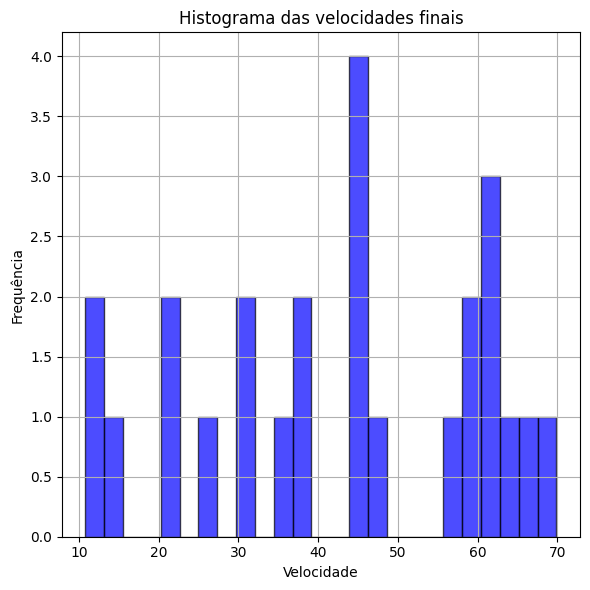

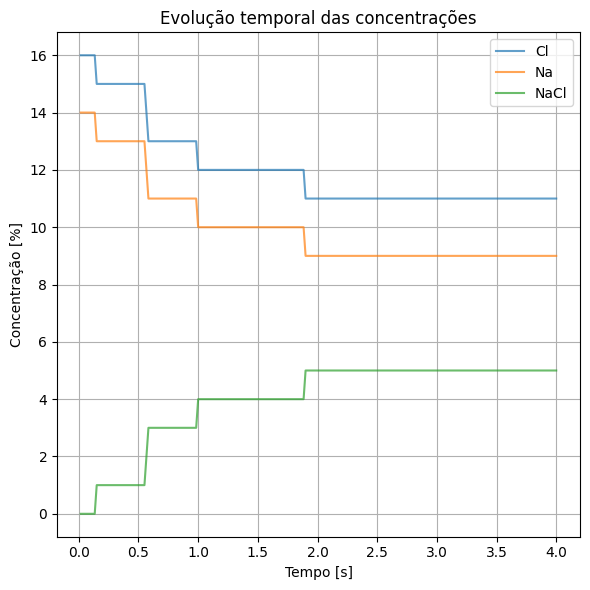

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
#Debugging 13-10-2023 == FALSE_V1; LATEST STABLE == V1
#UI == pygame
#Implementado gráfico Max-Boltz
#'future' funciona (inherited 6_10)
#Colisão inelástica e elástica implementada
#Colisão futura implementada em classe Particul
#Reação química feita + grafico conc./tempo
#Fazer: encontrar a lei de velocidade (derivadas)
#Problema: não usa grid (menos eficiente)


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 30
GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

NAME_BOLTZ = 'max-boltz_6_15.png'
NAME_CONCENTRATION_PLOT = 'concentration_6_15.png'

# Indexes de moléculas das reações
NA_CL_INDEX = 0
CHANCE_NACL_GLOBAL = 0.4 #chances de não acontecer a reação

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    chance_NaCl_local = random.random() #chanc de acontecer a reação

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    #print('old_particles:', particles)


    if ((p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na')) and (chance_NaCl_local > CHANCE_NACL_GLOBAL):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = 5
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)

        sprites.add(particle_instance.sprite_pygame)
        
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()


    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    #print('new_particles:',particles)
    #print()
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print('resolution',p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula




def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 5, "color": (255, 0, 0)}, #approximations
        "Cl": {"massa": 35, "raio": 5, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-60, 60) #velocidade inicial não especificada
        vel_y = random.uniform(-60, 60)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas

def select_particles(particles,sprites):
    particles_update = set()
    particles_remove = []

    #print('entrou pra selected')

    particle_pairs = np.array(list(itertools.combinations(particles.items(), 2)))
    #print('pares',particle_pairs)

    for (name_p1, instance_p1), (name_p2, instance_p2) in particle_pairs:
        #print((name_p1, type(instance_p1)), (name_p2, type(instance_p2)))
        if check_collision(instance_p1, instance_p2):
            #print('foi pra reacted')
            reacted_particles = reaction_collision(particles, instance_p1, name_p1, instance_p2, name_p2,sprites)
            

            if particles != reacted_particles:
                particles_update.update(reacted_particles)
                particles_remove.extend([name_p1, name_p2])

    for particle_name in particles_remove:
        del particles[particle_name]

    particles.update(particles_update)

    return particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    particle_pairs = np.array(list(itertools.permutations(particles.items(), 2)))
    for (name_p1, instance_p1), (name_p2, instance_p2) in particle_pairs:
        if check_collision(instance_p1, instance_p2):
                particle_move = random.choice([[name_p1,instance_p1], [name_p2,instance_p2]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    #print(sprites)
    return sprites


def chemical_counter(particles,time_passed,df=None):

    chem_list = particles.keys()
    #n_moleculas = len(chem_list)

    element_count = {}  # Initialize an empty dictionary to store element counts

    for item in chem_list:
        element = item.split('_')[0]  # Extract the element (part before the underscore)
        if element in element_count:
            element_count[element] += 1  # Increment the count if the element already exists
        else:
            element_count[element] = 1  # Initialize count to 1 if the element is encountered for the first time

   # for key in element_count: #transforma em %
    #    element_count[key] /= n_moleculas


    df_chem_columns = np.append('Tempo',list(element_count.keys()))
    #print(df_chem_columns)
    chem_array = np.append(time_passed,list(element_count.values()))
    #print(chem_array)
    df_chem = pd.DataFrame(chem_array).T
    df_chem.columns = df_chem_columns

    if not df_chem.empty:
        #print('passa pelo None')
        df_chem = pd.concat([df, df_chem,], axis=0, ignore_index=True)

    return df_chem
    

def maxwell_boltzmann_plot(final_speeds,name):
    # Barplot/histograma das velocidades Max-Boltz.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Velocidade')
    plt.ylabel('Frequência')
    plt.title('Histograma das velocidades finais')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()


def concentration_plot(df_chem,name):
    # Lineplot das concentrações/tempo.
    df_chem.to_csv('concentracoes_tempo.csv', index=False)
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    for y_axis, labels in zip(df_chem.columns[1:],list(df_chem.columns)[1:]):
        plt.plot(df_chem['Tempo'],df_chem[y_axis] ,alpha=0.7, label=labels)
    plt.legend()
    plt.xlabel('Tempo [s]')
    plt.ylabel('Quantidade [un]')
    plt.title('Evolução temporal das concentrações')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()


def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    df_chem = pd.DataFrame()
    digito_atual = 0
    time_passed = 0

    #grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                maxwell_boltzmann_plot(final_speeds,name=NAME_BOLTZ) #desligado para debugging

                df_chem = df_chem.fillna(0)
                concentration_plot(df_chem,name=NAME_CONCENTRATION_PLOT)
                exit()

        #print('after_reaction')
        after_reaction_particles = select_particles(particles,sprites)
        #print(type(after_reaction_particles))

        time_passed += DT
        primeiro_digito = int(time_passed)

        if (digito_atual == 0) or (digito_atual != primeiro_digito):
            primeiro_digito = digito_atual
            #print('novo df_chem')
            df_chem = chemical_counter(after_reaction_particles,time_passed,df_chem)

        # Update particle positions after collision detection
        for particle_name, particle_instance in after_reaction_particles.items():
            particle_instance.deslocar()
            particle_instance.next_position() #usado para calcular if colisao == True
            #print('Debugger:',particle_instance.x, particle_instance.y, particle_instance.x_future, particle_instance.y_future)

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, after_reaction_particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        #print(time_passed)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()
